In [6]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# Data preparation
advertising = np.array([1.5, 2.0, 2.3, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
sales = np.array([5.2, 6.8, 7.5, 8.0, 9.0, 10.2, 11.5, 12.0, 13.5, 14.0, 15.0, 15.5, 16.2, 17.0, 18.0, 18.5, 19.5, 20.0, 21.0, 22.0])

# Calculate mean for centering
X_mean = advertising.mean()
X_centered = advertising - X_mean

# Create the PyMC model
with pm.Model() as model:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)  # intercept
    beta = pm.Normal("beta", mu=0, sigma=10)    # slope
    epsilon = pm.HalfNormal("epsilon", sigma=1)  # scale
    v = pm.Gamma("v", alpha=2, beta=0.1)        # degrees of freedom
    
    # Expected value
    mu = alpha + beta * X_centered
    
    # Likelihood
    y_obs = pm.StudentT("y_obs", nu=v, mu=mu, sigma=epsilon, observed=sales)
    
    # Inference
    idata = pm.sample(2000, tune=2000, return_inferencedata=True)

# Print summary of the model
summary = az.summary(idata, hdi_prob=0.94)
print("\nModel Summary:")
print(summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon, v]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.



Model Summary:
           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    14.021   0.091  13.857   14.194      0.001    0.001    7444.0   
beta      1.700   0.032   1.641    1.760      0.000    0.000    7037.0   
epsilon   0.378   0.076   0.241    0.520      0.001    0.001    5742.0   
v        21.102  13.758   1.772   46.225      0.158    0.114    6448.0   

         ess_tail  r_hat  
alpha      5732.0    1.0  
beta       5589.0    1.0  
epsilon    4628.0    1.0  
v          4764.0    1.0  


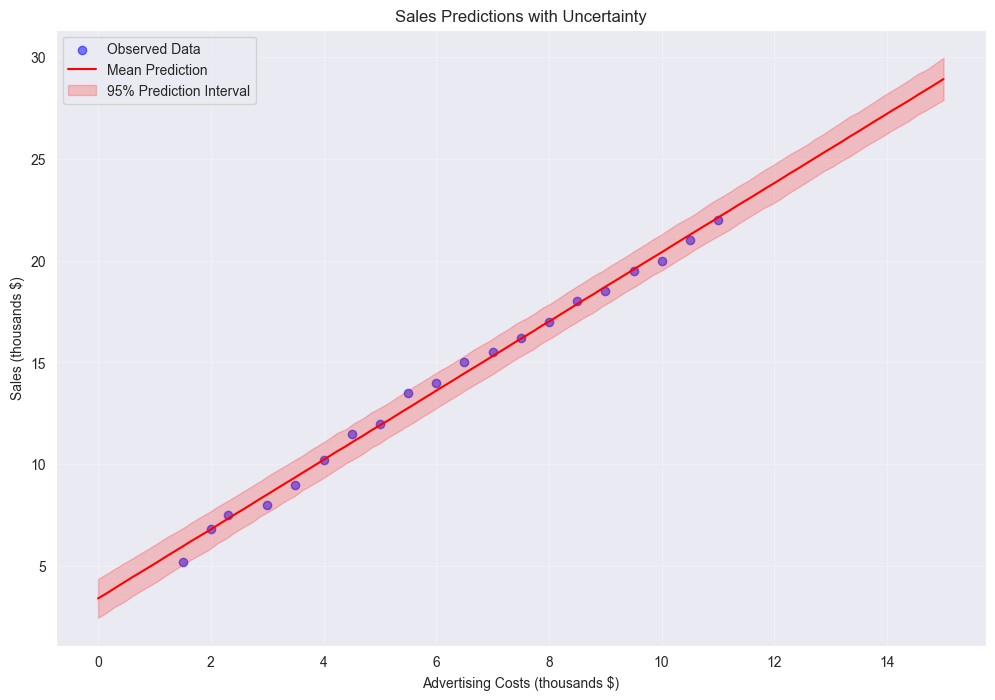


Predictions for specific advertising values:

Advertising = $12.0k:
  Predicted Sales = $23.8k
  95% Prediction Interval: $22.9k to $24.8k

Advertising = $13.0k:
  Predicted Sales = $25.5k
  95% Prediction Interval: $24.6k to $26.5k


In [7]:
def make_predictions(X_new, idata, X_mean, plot=True):
    """
    Generate predictions with uncertainty intervals using the trained PyMC model
    
    Parameters:
    X_new: array-like, new advertising values to predict for
    idata: arviz.InferenceData, contains the posterior samples
    X_mean: float, mean used to center the training data
    plot: boolean, whether to create visualization
    """
    # Center the new data
    X_new_centered = X_new - X_mean
    
    # Extract posterior samples
    posterior = idata.posterior
    alpha_samples = posterior.alpha.values.flatten()
    beta_samples = posterior.beta.values.flatten()
    epsilon_samples = posterior.epsilon.values.flatten()
    v_samples = posterior.v.values.flatten()
    
    # Initialize prediction array
    n_samples = len(alpha_samples)
    y_pred_samples = np.zeros((n_samples, len(X_new)))
    
    # Generate predictions for each posterior sample
    for i in range(n_samples):
        # Mean prediction
        mean_pred = alpha_samples[i] + beta_samples[i] * X_new_centered
        
        # Generate Student's t samples
        t_samples = np.random.standard_t(df=v_samples[i], size=len(X_new))
        # Transform to desired location and scale
        y_pred_samples[i] = mean_pred + epsilon_samples[i] * t_samples
    
    # Calculate summary statistics
    y_pred_mean = np.mean(y_pred_samples, axis=0)
    prediction_intervals = np.percentile(y_pred_samples, [2.5, 97.5], axis=0)
    
    if plot:
        plt.figure(figsize=(12, 8))
        # Plot original data
        plt.scatter(advertising, sales, color='blue', alpha=0.5, label='Observed Data')
        # Plot mean prediction line
        plt.plot(X_new, y_pred_mean, color='red', label='Mean Prediction')
        # Plot prediction intervals
        plt.fill_between(
            X_new, 
            prediction_intervals[0], 
            prediction_intervals[1],
            color='red', 
            alpha=0.2,
            label='95% Prediction Interval'
        )
        plt.xlabel('Advertising Costs (thousands $)')
        plt.ylabel('Sales (thousands $)')
        plt.title('Sales Predictions with Uncertainty')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return {
        'mean_predictions': y_pred_mean,
        'prediction_intervals': prediction_intervals,
        'samples': y_pred_samples
    }

# Example usage:
X_new = np.linspace(0, 15, 100)  # Including some extrapolation
predictions = make_predictions(X_new, idata, X_mean)

# For specific values:
test_points = np.array([12.0, 13.0])
test_predictions = make_predictions(test_points, idata, X_mean, plot=False)

print("\nPredictions for specific advertising values:")
for x, mean_pred, interval in zip(
    test_points,
    test_predictions['mean_predictions'],
    test_predictions['prediction_intervals'].T
):
    print(f"\nAdvertising = ${x}k:")
    print(f"  Predicted Sales = ${mean_pred:.1f}k")
    print(f"  95% Prediction Interval: ${interval[0]:.1f}k to ${interval[1]:.1f}k")